# Example of wind field generation with non-Gaussian wind field fluctuations

In [1]:
import numpy as np
from pyforwind import SWF
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rc('font', family='serif')

## Set the wind field box 

In [2]:
N_T = 512 # grid points in "temporal" direction
N_rotor = 21 # rotor plane

## Model parameters

In [3]:
H = 1./3. # Hurst exponent, determines power law of Kaimal spectrum                                                                                                                                                 
mu = 0.24 # intermittency coefficient                                                                                                                                                                               
L = 340.2 # integral length scale in Kaimal spectrum                                                                                                                                                                
L_c = 340.2 # correlation length in Kaimal coherences                                                                                                                                                               
T = 1200 # length of time series 
diam = 200. # diameter
V_hub = 8. # hub wind speed
h_hub = 100. # hub height

## Generate Kaimal, Temporal Superstat. Kaimal, and Spatiotemporal Superstat. Kaimal wind fields with identical seeds

In [4]:
swf_gauss = SWF(L, mu, V_hub, h_hub, (T, diam), (N_T, N_rotor), kind='gauss')
swf_temporal = SWF(L, mu, V_hub, h_hub, (T, diam), (N_T, N_rotor), kind='temporal')
swf_spatiotemporal = SWF(L, mu, V_hub, h_hub, (T, diam), (N_T, N_rotor), kind='spatiotemporal')
realizations = 1 # number of realizations
u_gauss = np.zeros((realizations, N_rotor, N_rotor, N_T))
u_temporal = np.zeros((realizations, N_rotor, N_rotor, N_T))
u_spatiotemporal = np.zeros((realizations, N_rotor, N_rotor, N_T))
seed = 12
for nn in range(realizations):
    u_gauss[nn] = swf_gauss.field(seed)
    u_temporal[nn] = swf_temporal.field(seed)
    u_spatiotemporal[nn] = swf_spatiotemporal.field(seed)
    seed += 1

## Plot slice of wind fields

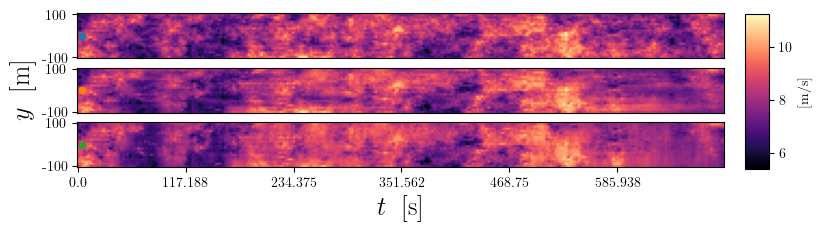

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,2))
length= 300
real = 0 # which realization to plot
xticks = np.array([0, 50, 100, 150, 200, 250])
ax = axes.flat[0]
im = ax.imshow(u_gauss[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), 
               vmax=u_gauss[real,8,:,:length].max(),origin='lower', cmap='magma')
ax.set_yticks([0,20], [-100,100])
ax.get_xaxis().set_visible(False)
ax.scatter(2, 10, s=20, color='C0')
ax = axes.flat[1]
im = ax.imshow(u_temporal[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), 
               vmax=u_gauss[real,8,:,:length].max(), origin='lower', cmap='magma')
ax.scatter(2, 10, s=20, color='C1')
ax.set_yticks([0,20], [-100,100])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('$y\;\; \\textrm{[m]}$', fontsize=19)
ax = axes.flat[2]
im = ax.imshow(u_spatiotemporal[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), 
               vmax=u_gauss[real,8,:,:length].max(), origin='lower', cmap='magma')
ax.scatter(2, 10, s=20, color='C2')
ax.set_xlabel('$t\;\; \\textrm{[s]}$', fontsize=19)
ax.set_xticks(xticks, np.round(xticks/N_T*T,3))
ax.set_yticks([0,20], [-100,100])
ax.grid(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.102, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax, label='\\textrm{[m/s]}');
#plt.savefig('kaimal_extract.pdf', bbox_inches='tight')

## Extract and plot time series 

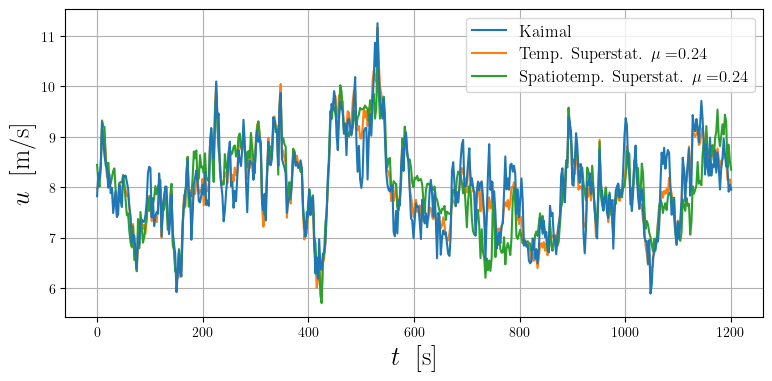

In [6]:
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(9, 4))
t = np.linspace(0, T, N_T)
ax.plot(t, u_gauss[real,8,10,:], label='Kaimal', color='C0',zorder=12)
ax.plot(t, u_temporal[real,8,10, :], label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(t, u_spatiotemporal[real,8,10, :], label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.legend(fontsize=12)
ax.set_ylabel('$u\;\; \\textrm{[m/s]}$', fontsize=19)
ax.set_xlabel('$t\;\; \\textrm{[s]}$', fontsize=19);
plt.savefig('time_series.pdf', bbox_inches='tight')

## Calculate statistical quantities (structure functions, spectra)

In [7]:
tau = np.logspace(0.2, 2.5, 20, dtype='int')
u_rms_gauss = np.std(u_gauss)
u_rms_temporal = np.std(u_temporal)
u_rms_spatiotemporal = np.std(u_spatiotemporal)
struc_2_gauss = np.zeros(tau.size)
struc_4_gauss = np.zeros(tau.size)
struc_2_temporal = np.zeros(tau.size)
struc_4_temporal = np.zeros(tau.size)
struc_2_spatiotemporal = np.zeros(tau.size)
struc_4_spatiotemporal = np.zeros(tau.size)
for rr in range(tau.size):
    struc_2_gauss[rr] = np.mean((np.roll(u_gauss, tau[rr], axis=3)-u_gauss)**2)
    struc_4_gauss[rr] = np.mean((np.roll(u_gauss, tau[rr], axis=3)-u_gauss)**4)
    struc_2_temporal[rr] = np.mean((np.roll(u_temporal, tau[rr], axis=3)-u_temporal)**2)
    struc_4_temporal[rr] = np.mean((np.roll(u_temporal, tau[rr], axis=3)-u_temporal)**4)
    struc_2_spatiotemporal[rr] = np.mean((np.roll(u_spatiotemporal, tau[rr], axis=3)-u_spatiotemporal)**2)
    struc_4_spatiotemporal[rr] = np.mean((np.roll(u_spatiotemporal, tau[rr], axis=3)-u_spatiotemporal)**4)
u_hat_gauss = np.fft.rfft(u_gauss, axis=3, norm='ortho')
u_hat_temporal = np.fft.rfft(u_temporal, axis=3, norm='ortho')
u_hat_spatiotemporal = np.fft.rfft(u_spatiotemporal, axis=3, norm='ortho')
spec_gauss = np.mean(np.abs(u_hat_gauss**2), axis=(0,1,2))
spec_temporal = np.mean(np.abs(u_hat_temporal**2), axis=(0,1,2))
spec_spatiotemporal = np.mean(np.abs(u_hat_spatiotemporal**2), axis=(0,1,2))

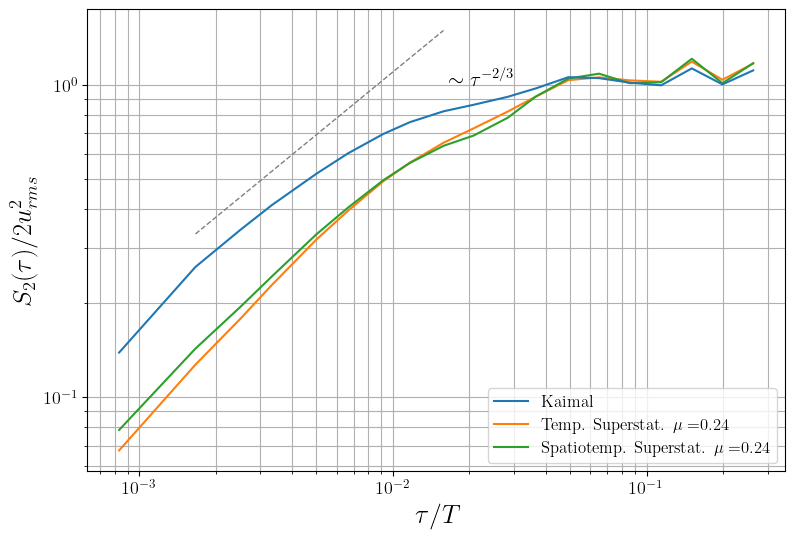

In [8]:
# Plot second-order structure functions
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(tau/T, struc_2_gauss/u_rms_gauss**2/2., label='Kaimal', color='C0',zorder=12)
ax.loglog(tau/T, struc_2_temporal/u_rms_temporal**2/2., label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.loglog(tau/T, struc_2_spatiotemporal/u_rms_spatiotemporal**2/2., 
          label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.legend(fontsize=12)
ax.set_ylabel('$S_2(\\tau)/2 u_{rms}^2$', fontsize=19)
ax.set_xlabel('$\\tau/T$', fontsize=19)
ax.text(20./T, 1., '$\\sim \\tau^{-2/3}$', fontsize=15)
ax.loglog(tau[2:10]/T, 0.21*tau[2:10]**(2/3.), color='grey', ls='dashed', lw=1)
ax.legend(fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.grid(True, which='Both')

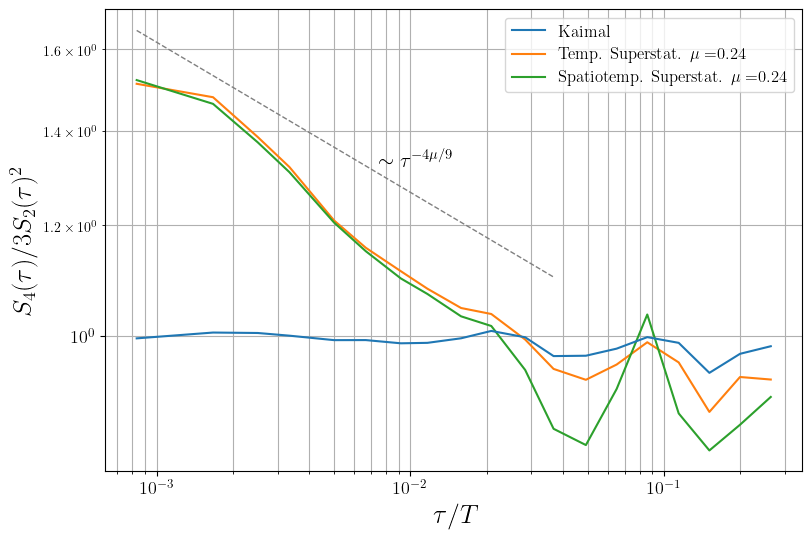

In [9]:
# Plot flatness of wind field fluctuations
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(tau/T, struc_4_gauss/(3.*struc_2_gauss**2), label='Kaimal', color='C0',zorder=12)
ax.loglog(tau/T, struc_4_temporal/(3.*struc_2_temporal**2), label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.loglog(tau/T, struc_4_spatiotemporal/(3.*struc_2_spatiotemporal**2), label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.loglog(tau[:-7]/T, 1.65*tau[:-7]**(-4.*mu/9.), color='grey', ls='dashed', lw=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.text(9/T, 1.32, '$\\sim \\tau^{-4\\mu/9}$', fontsize=15)
ax.set_ylabel('$S_4(\\tau)/3 S_2(\\tau)^2$', fontsize=19)
ax.set_xlabel('$\\tau/T$', fontsize=19)
ax.legend(fontsize=12)
ax.grid(True, which='Both')

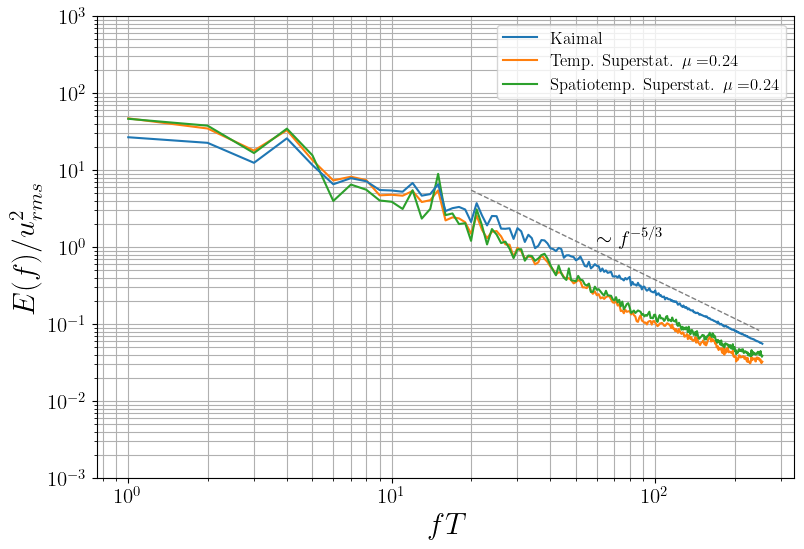

In [10]:
# Plot spectra averaged over rotor plane
fig, ax = plt.subplots(figsize=(9, 6))
plt.ylim(10**(-3), 10**(3))
f = np.fft.fftfreq(N_T, d=T/N_T)[:N_T//2+1]
#print(f)
ax.loglog(f[1:-1]*T, spec_gauss[1:-1]/u_rms_gauss**2, label='Kaimal', color='C0',zorder=12)
ax.loglog(f[1:-1]*T, spec_temporal[1:-1]/u_rms_temporal**2, label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.loglog(f[1:-1]*T, spec_spatiotemporal[1:-1]/u_rms_spatiotemporal**2, 
          label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.loglog(f[20:-8]*T, 0.006*f[20:-8]**(-5./3.), color='grey', ls='dashed', lw=0.98)
ax.text(60, 1.1, '$\\sim f^{-5/3}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$fT$', fontsize=22)
plt.ylabel('$E(f)/u_{rms}^2$', fontsize=22)
#ax.text(150, 2.9, '$\\sim f^{-5/3}$', fontsize=15)
ax.legend(fontsize=12)
ax.grid(True, which='Both')

## Generate increment PDFs

In [11]:
def inc_pdf(u_inst, R_PDF, bins, u_max):
    pdf_inc = np.zeros((R_PDF.size, bins))
    std_inc = np.zeros(R_PDF.size)
    for nn in range(u_inst.shape[0]):
        for rr in range(R_PDF.size):
            inc_x = np.roll(u_inst[nn],R_PDF[rr], axis=2)[:,:,R_PDF[rr]:]-u_inst[nn][:,:,R_PDF[rr]:]
            pdf_inst_x, edges = np.histogram(inc_x, bins=bins, range=[-u_max,u_max])
            pdf_inc[rr] += pdf_inst_x
            std_inc[rr] += np.std(inc_x)/realizations
    return std_inc, pdf_inc

In [12]:
bins = 256
R_PDF = np.array([1, 15, 100, 150])
u_max = 3.5
std_gauss, pdf_gauss = inc_pdf(u_gauss, R_PDF, bins, u_max)
pdf_gauss = np.ma.masked_where(pdf_gauss ==0, pdf_gauss)
std_temporal, pdf_temporal = inc_pdf(u_temporal, R_PDF, bins, u_max)
pdf_temporal = np.ma.masked_where(pdf_temporal ==0, pdf_temporal)
std_spatiotemporal, pdf_spatiotemporal = inc_pdf(u_spatiotemporal, R_PDF, bins, u_max)
pdf_spatiotemporal = np.ma.masked_where(pdf_spatiotemporal ==0, pdf_spatiotemporal)
v_neu = np.linspace(-u_max, u_max, bins)

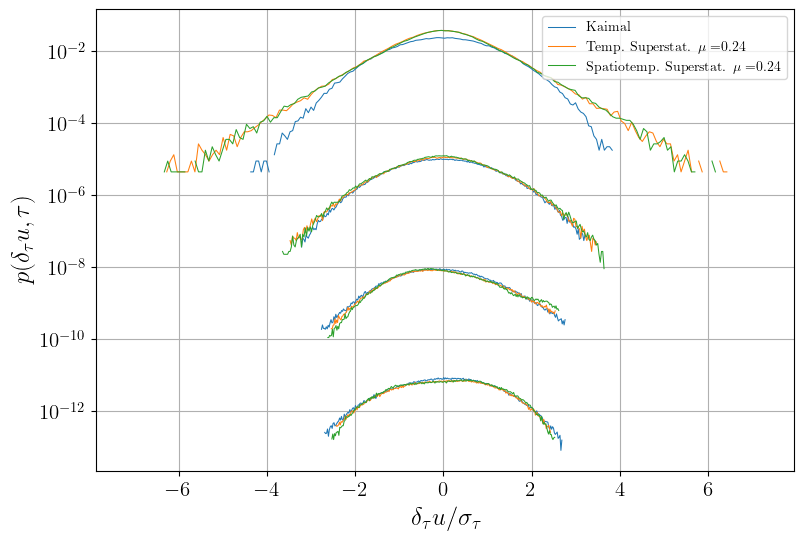

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
for rr in range(R_PDF.size-1):
    ax.plot(v_neu/std_gauss[rr], pdf_gauss[rr]/np.sum(pdf_gauss[rr])*10**(-3*rr), lw = 0.75, color='C0')
    ax.plot(v_neu/std_temporal[rr], pdf_temporal[rr]/np.sum(pdf_temporal[rr])*10**(-3*rr), lw = 0.75, color='C1')
    ax.plot(v_neu/std_spatiotemporal[rr], pdf_spatiotemporal[rr]/np.sum(pdf_spatiotemporal[rr])*10**(-3*rr), lw = 0.75, color='C2')
ax.plot(v_neu/std_gauss[-1], pdf_gauss[-1]/np.sum(pdf_gauss[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Kaimal', color='C0')
ax.plot(v_neu/std_temporal[-1], pdf_temporal[-1]/np.sum(pdf_temporal[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(v_neu/std_spatiotemporal[-1], pdf_spatiotemporal[-1]/np.sum(pdf_spatiotemporal[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.set_yscale('log')
plt.xlabel('$\\delta_{\\tau} u/\\sigma_\\tau$', fontsize=18)
plt.ylabel('$p(\\delta_{\\tau} u, \\tau)$', fontsize=18)
ax.legend(frameon=True)
#label='$r= {0:.3f}$'.format(r)+'$L$',
plt.grid(True, which='Both')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);